# Test code for interferometer analysis
Code reads in background image and jet image. It analyses the two images side by side before subtracting the background from the jet at the end.
Current issues:
- Spectral filter is not working properly. Need to optimise shape and position.
- Not sure if scaling of image to 4pi before phase unwrapping is required or not.
- Phase unwrapping is not providing expected result; could be because of either of the issues above.

# Import packages

In [251]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import LogNorm
from PIL import Image
import numpy as np
from scipy import fftpack
from skimage import exposure
from skimage.restoration import unwrap_phase

# Read in images

In [252]:
bgRawImage = np.array(Image.open('BG1.tif'), dtype=np.float)
jetRawImage = np.array(Image.open('8bar1.tif'), dtype=np.float)

# Show images with ROI marked

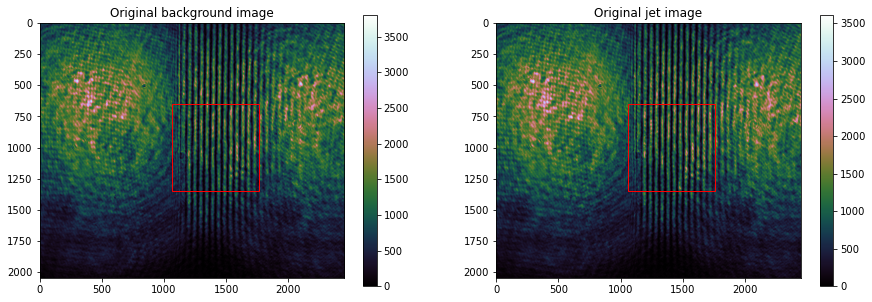

In [253]:
rectHor = 1060
rectVer = 650
rectWidth = 700
rectHeight = 700
fig,(axBg, axJet) = plt.subplots(1,2,figsize=(15,5))
rectBg = patches.Rectangle((rectHor,rectVer),rectWidth,rectHeight,linewidth=1,edgecolor='r',facecolor='none') # (Hor,Ver), W,H
rectJet = patches.Rectangle((rectHor,rectVer),rectWidth,rectHeight,linewidth=1,edgecolor='r',facecolor='none') # (Hor,Ver), W,H
axBg.add_patch(rectBg)
axJet.add_patch(rectJet)
axBg.imshow(bgRawImage, plt.cm.cubehelix)
axJet.imshow(jetRawImage, plt.cm.cubehelix)
axBg.set_title('Original background image')
axJet.set_title('Original jet image')
fig.colorbar(plt.cm.ScalarMappable(norm=plt.Normalize(vmin=0, vmax=np.max(bgRawImage)),cmap=plt.cm.cubehelix), ax=axBg)
fig.colorbar(plt.cm.ScalarMappable(norm=plt.Normalize(vmin=0, vmax=np.max(jetRawImage)),cmap=plt.cm.cubehelix), ax=axJet)

# Select ROI for analysis

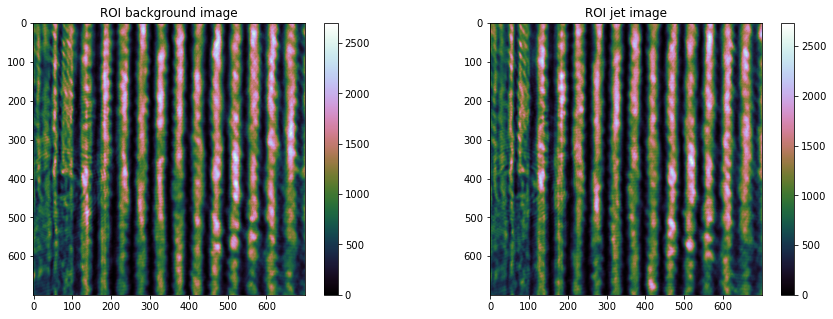

In [254]:
bgROIImage = bgRawImage[rectVer:rectVer+rectHeight,rectHor:rectHor+rectWidth]
jetROIImage = jetRawImage[rectVer:rectVer+rectHeight,rectHor:rectHor+rectWidth]

fig,(axBg, axJet) = plt.subplots(1,2,figsize=(15,5))
axBg.imshow(bgROIImage, plt.cm.cubehelix)
axJet.imshow(jetROIImage, plt.cm.cubehelix)
axBg.set_title('ROI background image')
axJet.set_title('ROI jet image')
fig.colorbar(plt.cm.ScalarMappable(norm=plt.Normalize(vmin=0, vmax=np.max(bgROIImage)),cmap=plt.cm.cubehelix), ax=axBg)
fig.colorbar(plt.cm.ScalarMappable(norm=plt.Normalize(vmin=0, vmax=np.max(jetROIImage)),cmap=plt.cm.cubehelix), ax=axJet)

# FFT - filter size and position defined here

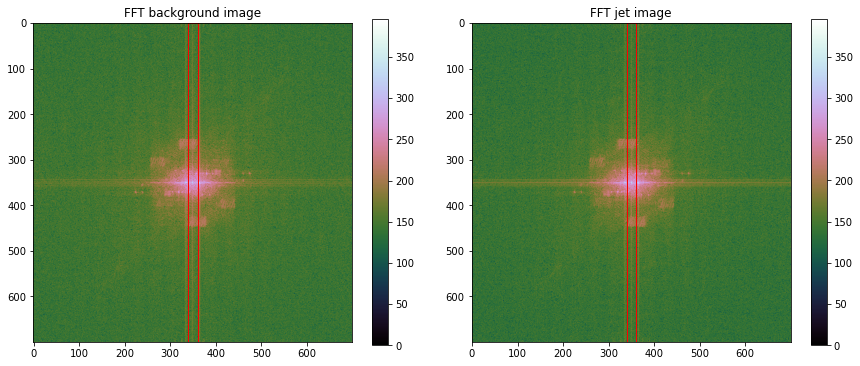

In [255]:
bgFFT = np.fft.fft2(bgROIImage)
jetFFT = np.fft.fft2(jetROIImage)
bgFFTShift = np.fft.fftshift(bgFFT)
jetFFTShift = np.fft.fftshift(jetFFT)
bgMagSpec = 20*np.log(np.abs(bgFFTShift))
jetMagSpec = 20*np.log(np.abs(jetFFTShift))

fig,(axBg, axJet) = plt.subplots(1,2,figsize=(15,6))
plt.subplots_adjust(wspace=0.1)
filterWidth = 20
filterHeight = 700
filterHor = rectWidth/2 - filterWidth/2
filterVer = rectHeight/2 - filterHeight/2
rectBg = patches.Rectangle((filterHor,filterVer),filterWidth,filterHeight,linewidth=1,edgecolor='r',facecolor='none') # (Hor,Ver), W,H
rectJet = patches.Rectangle((filterHor,filterVer),filterWidth,filterHeight,linewidth=1,edgecolor='r',facecolor='none') # (Hor,Ver), W,H
axBg.add_patch(rectBg)
axJet.add_patch(rectJet)
axBg.imshow(bgMagSpec, plt.cm.cubehelix)
axJet.imshow(jetMagSpec, plt.cm.cubehelix)
axBg.set_title('FFT background image')
axJet.set_title('FFT jet image')
fig.colorbar(plt.cm.ScalarMappable(norm=plt.Normalize(vmin=0, vmax=np.max(bgMagSpec)),cmap=plt.cm.cubehelix), ax=axBg)
fig.colorbar(plt.cm.ScalarMappable(norm=plt.Normalize(vmin=0, vmax=np.max(jetMagSpec)),cmap=plt.cm.cubehelix), ax=axJet)

# Spectral filter

<ipython-input-256-a4028f70dfdc>:23: RuntimeWarning: divide by zero encountered in log
  bgMagSpecFilt = 20*np.log(np.abs(bgFFTCopy))
<ipython-input-256-a4028f70dfdc>:24: RuntimeWarning: divide by zero encountered in log
  jetMagSpecFilt = 20*np.log(np.abs(jetFFTCopy))


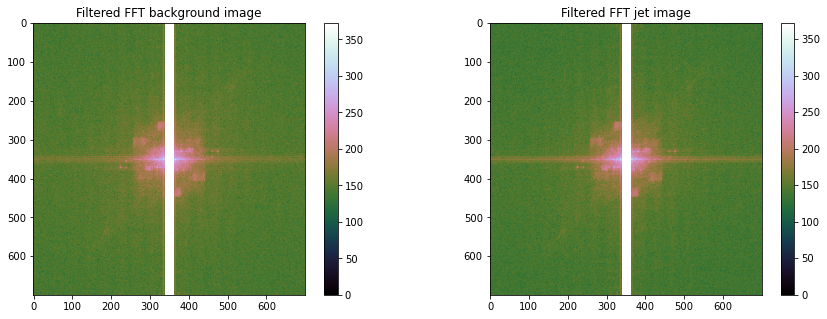

In [256]:
#keep_fraction = 0.1

bgFFTCopy = bgFFTShift.copy()
jetFFTCopy = jetFFTShift.copy()

bgFFTRows, bgFFTCols = bgFFTCopy.shape
jetFFTRows, jetFFTCols = jetFFTCopy.shape

for i in range(1,bgFFTRows):
    for j in range(1,bgFFTCols):
        if i>filterHor and i<filterHor+filterWidth and j>filterVer and j<filterVer+filterHeight:
            bgFFTCopy[j,i] = 0.0
            jetFFTCopy[j,i] = 0.0
        else:
            bgFFTCopy[j,i] = bgFFTCopy[j,i]
            jetFFTCopy[j,i] = jetFFTCopy[j,i]

#bgFFTCopy[int(bgFFTRows*keep_fraction):int(bgFFTRows*(1-keep_fraction))] = 0.0
#bgFFTCopy[:,int(bgFFTCols*keep_fraction):int(bgFFTCols*(1-keep_fraction))] = 0.0
#jetFFTCopy[int(jetFFTRows*keep_fraction):int(jetFFTRows*(1-keep_fraction))] = 0.0
#jetFFTCopy[:,int(jetFFTCols*keep_fraction):int(jetFFTCols*(1-keep_fraction))] = 0.0

bgMagSpecFilt = 20*np.log(np.abs(bgFFTCopy))
jetMagSpecFilt = 20*np.log(np.abs(jetFFTCopy))
fig,(axBg, axJet) = plt.subplots(1,2,figsize=(15,5))
axBg.imshow(bgMagSpecFilt, plt.cm.cubehelix)
axJet.imshow(jetMagSpecFilt, plt.cm.cubehelix)
axBg.set_title('Filtered FFT background image')
axJet.set_title('Filtered FFT jet image')
fig.colorbar(plt.cm.ScalarMappable(norm=plt.Normalize(vmin=0, vmax=np.max(bgMagSpecFilt)),cmap=plt.cm.cubehelix), ax=axBg)
fig.colorbar(plt.cm.ScalarMappable(norm=plt.Normalize(vmin=0, vmax=np.max(jetMagSpecFilt)),cmap=plt.cm.cubehelix), ax=axJet)

# Filtered images

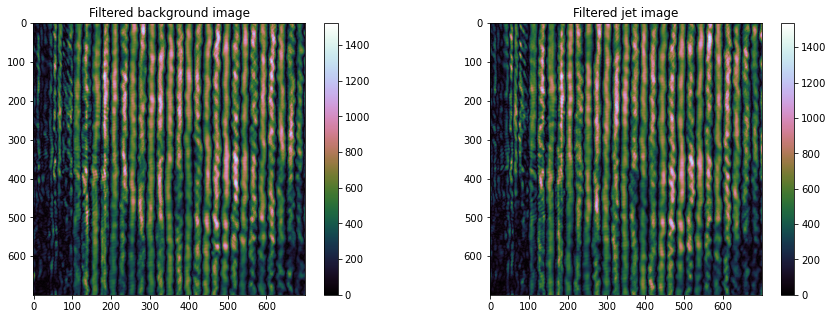

In [257]:
bgFilShift = fftpack.ifftshift(bgFFTCopy)
jetFilShift = fftpack.ifftshift(jetFFTCopy)
bgFilImage = np.abs(fftpack.ifft2(bgFilShift))
jetFilImage = np.abs(fftpack.ifft2(jetFilShift))

fig,(axBg, axJet) = plt.subplots(1,2,figsize=(15,5))
axBg.imshow(bgFilImage, plt.cm.cubehelix)
axJet.imshow(jetFilImage, plt.cm.cubehelix)
axBg.set_title('Filtered background image')
axJet.set_title('Filtered jet image')
fig.colorbar(plt.cm.ScalarMappable(norm=plt.Normalize(vmin=0, vmax=np.max(bgFilImage)),cmap=plt.cm.cubehelix), ax=axBg)
fig.colorbar(plt.cm.ScalarMappable(norm=plt.Normalize(vmin=0, vmax=np.max(jetFilImage)),cmap=plt.cm.cubehelix), ax=axJet)

# Scale images - NOT SURE IF THIS IS NEEDED

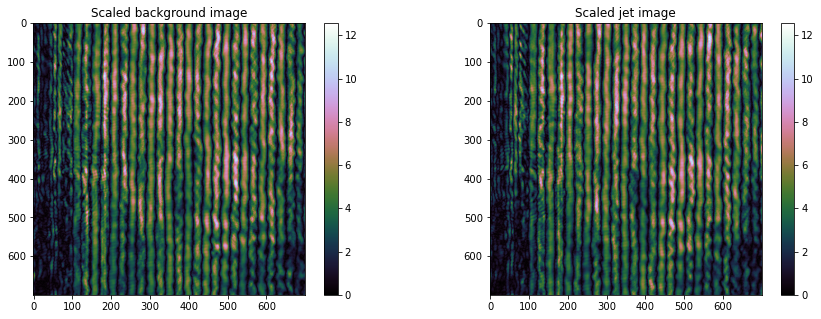

In [258]:
bgScaledImage = exposure.rescale_intensity(bgFilImage, out_range=(0, 4 * np.pi))
jetScaledImage = exposure.rescale_intensity(jetFilImage, out_range=(0, 4 * np.pi))

fig,(axBg, axJet) = plt.subplots(1,2,figsize=(15,5))
axBg.imshow(bgScaledImage, plt.cm.cubehelix)
axJet.imshow(jetScaledImage, plt.cm.cubehelix)
axBg.set_title('Scaled background image')
axJet.set_title('Scaled jet image')
fig.colorbar(plt.cm.ScalarMappable(norm=plt.Normalize(vmin=0, vmax=np.max(bgScaledImage)),cmap=plt.cm.cubehelix), ax=axBg)
fig.colorbar(plt.cm.ScalarMappable(norm=plt.Normalize(vmin=0, vmax=np.max(jetScaledImage)),cmap=plt.cm.cubehelix), ax=axJet)

# Unwrap phase

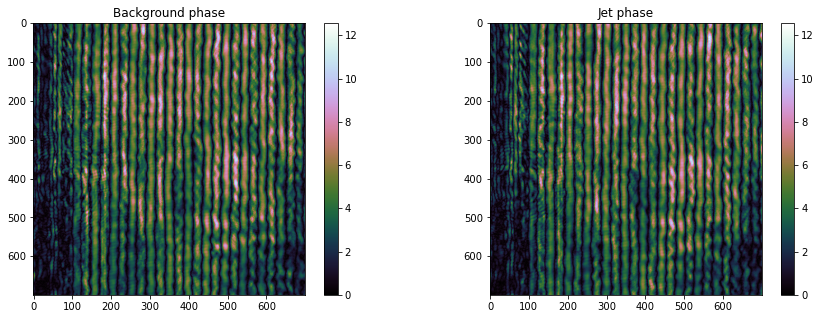

In [259]:
#bgPhase = bgFilImage
#jetPhase = jetFilImage
#for i in range(1,rectWidth):
#    bgPhase[i,:] = np.unwrap(bgFilImage[i,:],0)
#    jetPhase[i,:] = np.unwrap(jetFilImage[i,:],0)
#for i in range(1,rectHeight):
#    bgPhase[:,i] = np.unwrap(bgFilImage[:,i],0)
#    jetPhase[:,i] = np.unwrap(jetFilImage[:,i],0)
bgPhase = unwrap_phase(bgScaledImage)
jetPhase = unwrap_phase(jetScaledImage)

fig,(axBg, axJet) = plt.subplots(1,2,figsize=(15,5))
axBg.imshow(bgPhase, plt.cm.cubehelix)
axJet.imshow(jetPhase, plt.cm.cubehelix)
axBg.set_title('Background phase')
axJet.set_title('Jet phase')
fig.colorbar(plt.cm.ScalarMappable(norm=plt.Normalize(vmin=0, vmax=np.max(bgPhase)),cmap=plt.cm.cubehelix), ax=axBg)
fig.colorbar(plt.cm.ScalarMappable(norm=plt.Normalize(vmin=0, vmax=np.max(jetPhase)),cmap=plt.cm.cubehelix), ax=axJet)

# Subtract background

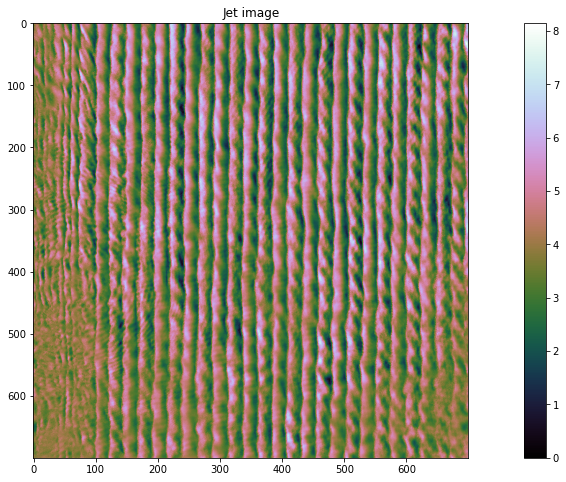

In [260]:
jetImage = jetPhase - bgPhase

fig,axJet = plt.subplots(1,1,figsize=(20,8))
axJet.imshow(jetImage, plt.cm.cubehelix)
axJet.set_title('Jet image')
fig.colorbar(plt.cm.ScalarMappable(norm=plt.Normalize(vmin=0, vmax=np.max(jetImage)),cmap=plt.cm.cubehelix), ax=axJet)